In [1]:
# Import required libraries
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pickle
import os

%matplotlib inline

In [2]:
# From series of checkerboard images, find the mapping between image points and object points

def map_imgpts_wid_objpts(imgpts, objpts, fixedobjpts):
    
    files = glob.glob("camera_cal/calibration*.jpg")
    imagesize = None
    
    for file in files:
        
        #Read individual calibration file
        img = cv2.imread(file)
        
        #Convert image into grayscale before finding chessboard corners
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find Chessboard corners
        ret, corners = cv2.findChessboardCorners(img, (9,6))
        
        # If all corners are found then append the corners in imgpts
        if ret == True:
            objpts.append(fixedobjpts)
            imgpts.append(corners)
            imagesize = img.shape[0:2]
    
    return ret,imagesize
    

In [3]:
# Calibrate camera with the calculated map between image points and object points

def calibrate_camera(imgpts, objpts, imgsize, mtx, dist, picklefile):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, imgsize, None, None)
    
    # Save camera matrix and distortion coefficients to the file
    pick = {}
    pick['mtx'] = mtx
    pick['dist'] = dist
    
    pickle.dump(pick, open(picklefile, "wb"))
    
    print("Camera Calibration done, saving the camera matrix and distortion coefficients as pickle file")
    
    return ret

In [4]:
#Undistort test image

def undistort_image(img, mtx, dist, outimg):
    
    outimg = cv2.undistort(img, mtx, dist)
    
    # Plot original and undistorted image
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(outimg)
    ax2.set_title('Undistorted Image')
    
    

In [5]:
# Onetime calibration of camera
def onetime_calibrate_camera():
    picklefile = 'camera_calibration.p'
    fixedobjpts = np.zeros((6*9,3), np.float32)
    fixedobjpts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpts = []
    imgpts = []
    ret,imgsize = map_imgpts_wid_objpts(imgpts, objpts, fixedobjpts)
    mtx = None
    dist = None
    if ret == True:
        calibrate_camera(imgpts, objpts, imgsize, mtx, dist, picklefile)
        

Camera calibration not done
Camera Calibration done, saving the camera matrix and distortion coefficients as pickle file


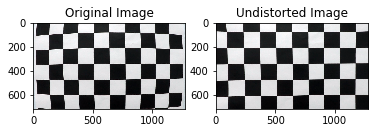

In [6]:
# Load the pickle file with camera matrix and distortion coefficients and check the undistorted image

test_img = cv2.imread("camera_cal/calibration1.jpg")

picklefile = 'camera_calibration.p'
if (os.path.exists(picklefile) == False):
    print("Camera calibration not done")
    onetime_calibrate_camera()
else:
    print("Camera calibration already done")

f = open(picklefile, "rb")
pick = pickle.load(f)
mtx = pick['mtx']
dist = pick['dist']
out_img = np.zeros_like(test_img)
undistort_image(test_img, mtx, dist, out_img)
    

In [7]:
# Advanced Lane Detection Pipeline

def pipeline(img, mtx, dist):
    
    #Step 1: Undistort the image
    undistort(img, mtx, dist, out_img)